In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import cvxpy as cp
import ot
import json
from networkx.readwrite import json_graph
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import pairwise_distances

2024-12-19 14:16:58.537290: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data

To apply these distances, we need the state's adjancency graph and shapefile. 

In [2]:
json_file = 'NC_pct21.json'
with open(json_file) as f:
    data = json.load(f)
g = json_graph.adjacency_graph(data)

In [3]:
shapefile_file = 'pct21/pct21.shp'
pctSF = gpd.read_file(shapefile_file)

Let's load in districts as binary vectors, and pick two to work with as examples.

In [4]:
district_vectors = np.array(np.load('dense_100plans_NC.npy'), dtype=np.int32)

In [5]:
district_vectors.shape

(1400, 2650)

<Axes: >

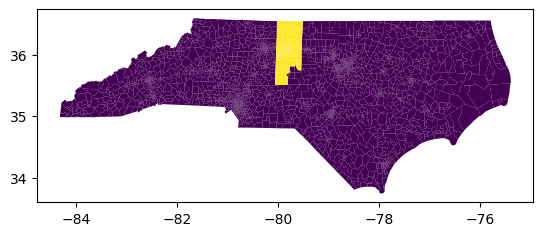

In [6]:
A = district_vectors[2]
pctSF.plot(column=A)

<Axes: >

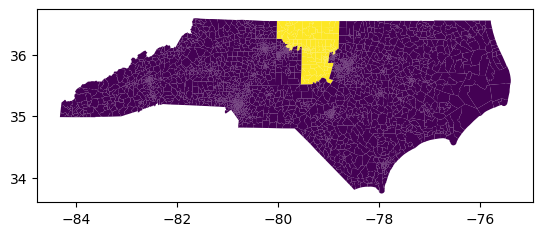

In [7]:
B = district_vectors[52]
pctSF.plot(column=B)

## Metric 1: Graph optimal transport

This distance between districts is introduced [here](https://epubs.siam.org/doi/abs/10.1137/19M1295258?casa_token=lhazdbnUr7wAAAAA:o0-vUhDCopNlAjOp7uLKvSIyj0IrOYoEHHxu3jWBDfqLJnk76hoGCXd4HgtEyunITwd3CkTjv18). Treat each district as a probability distribution* on the underlying adjacency graph and compute the 1-Wasserstein distance with the path length metric. We use a flow reformulation instead of using all vs all distances, where $x$ and $y$ are the districts as distributions and $P$ is the edge-incidence matrix:

$$
W_1(x,y)=\left\{
    \begin{array}{rl}
    \min\limits_{J\in \mathbb{R}^{|E|}} & \sum\limits_{e\in E}|J_e|\\
    \text{s.t.} & P^\top J = y-x,
    \end{array}
    \right.
$$

**Pros:** Path length permits a somewhat apples-to-apples comparison between distances in high-population and low-population areas. Indeed, since cities typically have lots of precincts, hence lots of nodes and edges, a mile in a city is like ten miles in the country.

**Cons:** Expensive to compute because you need to solve an LP. Not obvious how to approximate.

*either uniform on support or proportional to population density

In [8]:
P = nx.incidence_matrix(g, oriented=True)
n_edges = P.shape[1]
J = cp.Variable(n_edges)
diff = B/sum(B) - A/sum(A) #normalize to equal weight, thought one can do an unbalanced version (see the paper)
objective = cp.Minimize(cp.sum(cp.abs(J)))
prob = cp.Problem(objective, [P @ J == diff])
prob.solve()
d = np.sum(np.abs(J.value))

In [9]:
d

6.782967065374562

## Method 2: Planar optimal transport

This distance was used [here](https://epubs.siam.org/doi/full/10.1137/21M1436580?casa_token=hu-KxkwoiAQAAAAA%3AaLjZV9JqyluoJG7D3F-blz9DnThqt_BwygxR4LaoawTH0WKoXi6ojUBPg0y6T8HEFgMNwGnx2yk). We treat each district as a distribution in the plane* and compute a 2-Wasserstein distance (or other Wasserstein distance). Because it is hard to handle the planar distribution as a union of polygons, we historically resorted to sampling a set of precinct centroids, and using the empirical distribution as an approximation. This allows us to solve the discrete problem

$$
d(\mathbf{a}, \mathbf{b}) = \min_P \sqrt{ \sum_{ij} P_{ij} \cdot d(a_i, b_j)^2 }
$$
where $\mathbf{a} = (a_1, \ldots, a_n)$ and $\mathbf{b} = (b_1, \ldots, b_n)$ are the samples for each district, and $P$ ranges over non-negative $n\times n$ matrices with $P \mathbf{1} = \mathbf{a}$ and $P^T \mathbf{1} = \mathbf{b}$. Standard theory dictates that there is an optimal $P$ which is a permutation matrix.

**Pros**: Quicker to compute since the linear program has size $n^2$ rather than $\text{edges} \times \text{vertices}$. Admits possible fast approximations via e.g. sliced Wasserstein. Can be used to compute Wasserstein barycenters (which we did in our paper).

**Cons**: Treats distances in the city the same as in the country; that is -- shifting a city district 1 mile West is the same as shifting a country district 1 mile West, but this seems unintuitive because the social and political effect feels bigger in the first case.

*either uniform on support or proportional to population density

In [10]:
#reproject the map to a better projection
pctSF = pctSF.to_crs('ESRI:103500') 

In [11]:
#get centroids and areas
centroids = np.array([x.coords[0] for x in pctSF.geometry.centroid])
areas = np.array(pctSF.geometry.area)

In [12]:
A_points = np.random.choice(np.arange(len(A)), size=40, p=A*areas/sum(A*areas))
A_empirical = centroids[A_points, :]
B_points = np.random.choice(np.arange(len(B)), size=40, p=B*areas/sum(B*areas))
B_empirical = centroids[B_points, :]

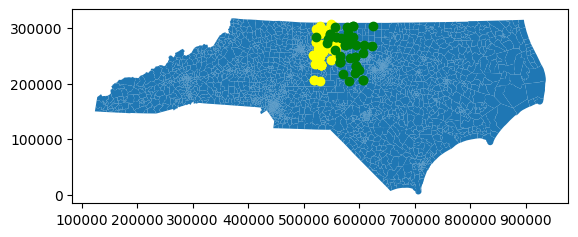

In [13]:
#just to check it looks right
pctSF.plot()
plt.scatter(A_empirical[:,0], A_empirical[:,1], c='yellow')
plt.scatter(B_empirical[:,0], B_empirical[:,1], c='green')

In [14]:
M = pairwise_distances(A_empirical, B_empirical)**2
rows, cols = linear_sum_assignment(M)
d = (M[rows, cols]/len(A_empirical)).sum()**(1/2)

In [15]:
d

46802.34676796151